# **Articles Categories Classification(Class Project)**

In [1]:
import requests
import bs4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# **Section 1 - Data Acquisition**

Gathering the article data from the main webpage 

In [6]:
# assign GET request result of the main page to main variable
main = requests.get("http://www.it.kmitl.ac.th/~teerapong/news_archive/index.html")

In [7]:
# transform to the BeautifulSoup object
main_page = bs4.BeautifulSoup(main.content, 'lxml')

In [8]:
# get all article function which is perform query all article from the main page
def get_all_article(html_page):
    main = html_page.select("a") # select the "a" tags from the main page which refer to the months link
    data = pd.DataFrame() # assign data frame for storing all of the article data
    for i in main: # Loop through the "a" tag stored in main variable
        # extract "href" tag of each link for dig into each month page
        sub = requests.get("http://www.it.kmitl.ac.th/~teerapong/news_archive/" + i["href"]) 
        sub_page = bs4.BeautifulSoup(sub.content, 'lxml')
        link = sub_page.select("td.title > a") # extract the link of each article
        category = sub_page.select("td.category") # extract article category
        category = list(filter(lambda x: x.text.strip() != "N/A", category)) # filter N/A out of the category records
        for j in range(len(category)): # loop through the list of article and category
            article = requests.get("http://www.it.kmitl.ac.th/~teerapong/news_archive/" + link[j]["href"]) # get each article page
            article = bs4.BeautifulSoup(article.content, 'lxml')
            head = article.select_one("h2").text # extract the title using H2 tag
            para_select = article.select("div.main > p") # extract article paragraph using p tag
            paragraph = " ".join([i.text.strip() for i in para_select[0:-1]]).replace(head, "") # join all the p tag together 
            temp = {
                "category": category[j].text.strip(),
                "head": head,
                "paragraph": paragraph,
                "articleWithHead": head + " " + paragraph
            }
            temp = pd.json_normalize(temp)
            data = data.append(temp, ignore_index=True) # gather in the appropriate form and append to te mentioned dataframe
    return data #return the full article dataframe

In [9]:
article_data = get_all_article(main_page) # assign the full dataframe of article data to article_data variable

In [13]:
# Cleaning by drop the title duplicate records
article_data = article_data.drop_duplicates(subset=["head"])

In [12]:
# drop the paragraph duplicate records
article_data = article_data.drop_duplicates(subset=["paragraph"])

In [15]:
article_data.shape

(1336, 4)

## **Files Saving**

In [25]:
!mkdir data
!mkdir data\datastore
!mkdir data\target

A subdirectory or file data already exists.
A subdirectory or file data\datastore already exists.
A subdirectory or file data\target already exists.


In [16]:
# save the dataframe to the csv format
article_data.to_csv("data/datastore/all_article.csv", index = False)

In [17]:
# save category data to txt file
np.savetxt(r"C:/Users/pond/Desktop/Y3/DS4B/Assignment2/data/target/category.txt", article_data["category"].values, fmt='%s')

In [18]:
# save article data to txt file
np.savetxt(r"C:/Users/pond/Desktop/Y3/DS4B/Assignment2/data/datastore/article.txt", article_data["paragraph"].values, fmt='%s', encoding="utf-8")

In [19]:
# save article with title data to txt file
np.savetxt("C:/Users/pond/Desktop/Y3/DS4B/Assignment2/data/datastore/article_withHead.txt", article_data["articleWithHead"].values, fmt='%s', encoding="utf-8")

# **Section 2 - Text Classification**

## **Text Preprocessing**

Perprocess the text by using various tokenizer

In [226]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder

In [3]:
#read from csv
data = pd.read_csv("data/datastore/all_article.csv")

### **Article File Read**

In [26]:
article_file = open("data/datastore/article.txt","r", encoding="utf-8")
article = article_file.readlines()
article_file.close()
print("Read %d raw text documents" % len(article))

Read 1336 raw text documents


### **Category File Read**

In [30]:
category_file = open("data/target/category.txt","r", encoding="utf-8")
category_read = category_file.readlines()
category_file.close()
print("Read %d raw text documents" % len(category_read))

Read 1336 raw text documents


### **Label Encoding for Target**

In [31]:
# clean the category by strip each word
category_read = [i.strip() for i in category_read]

In [34]:
# transform the category to number label using LabelEncoding
le = LabelEncoder()
le_trans = le.fit_transform(category_read)
print(category_read[0:10])
print(le_trans[0:10])

['technology', 'business', 'technology', 'business', 'sport', 'sport', 'sport', 'sport', 'technology', 'technology']
[2 0 2 0 1 1 1 1 2 2]


## **Text Tokenizer and Stemmer Function**

Create the various type of stemmer function for performing text token stemming 

In [27]:
import nltk

In [35]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pond\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pond\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### **Lancaster Stemmer**

In [37]:
def lancaster_stemmer(text):
    tokenizer = CountVectorizer().build_tokenizer()
    tokens = tokenizer(text)
    stemmer = nltk.stem.LancasterStemmer()
    stems = []
    for token in tokens:
        stems.append(stemmer.stem(token.lower()))
    return stems

**Display Sample Stemmed Terms**

In [231]:
vectorizer_lancaster = TfidfVectorizer(tokenizer=lancaster_stemmer)
vectorizer_lancaster.fit_transform(article)
print(list(vectorizer_lancaster.vocabulary_.keys())[0:20])

['the', 'sport', 'industry', 'has', 'com', 'long', 'way', 'sint', '60s', 'it', 'carv', 'out', 'for', 'itself', 'nich', 'with', 'root', 'so', 'deep', 'that']


### **Porter Stemmer**

In [40]:
def porter_stemmer(text):
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    stemmer = nltk.stem.PorterStemmer()
    stems = []
    for token in tokens:
        stems.append(stemmer.stem(token.lower()))
    return stems

**Display Sample Stemmed Terms**

In [229]:
vectorizer_porter_custom = TfidfVectorizer(tokenizer=porter_stemmer)
vectorizer_porter_custom.fit_transform(article)
print(list(vectorizer_porter_custom.vocabulary_.keys())[0:20])

['the', 'sport', 'industri', 'ha', 'come', 'long', 'way', 'sinc', '60', 'it', 'carv', 'out', 'for', 'itself', 'nich', 'with', 'root', 'so', 'deep', 'that']


### **Snowball Stemmer**

In [46]:
def snowball_stemmer(text):
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    stemmer = nltk.stem.SnowballStemmer(language="english")
    stems = []
    for token in tokens:
        stems.append(stemmer.stem(token.lower()))
    return stems

**Display Sample Stemmed Terms**

In [230]:
vectorizer_snowball = TfidfVectorizer(tokenizer=snowball_stemmer)
vectorizer_porter_custom.fit_transform(article)
print(list(vectorizer_porter_custom.vocabulary_.keys())[0:20])

['the', 'sport', 'industri', 'ha', 'come', 'long', 'way', 'sinc', '60', 'it', 'carv', 'out', 'for', 'itself', 'nich', 'with', 'root', 'so', 'deep', 'that']


### **WordNet Lemmatizer**

In [227]:
def lemma_tokenizer(text):
    # build tokenizer with scikit method
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # build wordnet lemma with nltk lemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append(lemmatizer.lemmatize(token.lower()))
    return lemma_tokens

**Display Sample Stemmed Terms**

In [232]:
vectorizer_lemma = TfidfVectorizer(tokenizer=lemma_tokenizer, stop_words="english", min_df = 5)
vectorizer_lemma.fit_transform(article)
print(list(vectorizer_lemma.vocabulary_.keys())[0:20])

['sporting', 'industry', 'ha', 'come', 'long', 'way', '60', 'niche', 'root', 'deep', 'sport', 'showing', 'sign', 'decline', 'time', 'soon', 'later', 'reason', 'seemingly', 'difference']


## **Model Building with Hyperparameter Tunning**

Performing Text Classification function by creating the classification model using RandomSearch Hyperparameter tuning by the given range of parameters 

In [233]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import Pipeline
from scipy import interp

get_best_model for tuning the best both vectorizer and model parameter for any model passing in the function

In [52]:
# get_best_model for tuning the vertorizer parameter and model parameter
def get_best_model(X, y, model, modelParam):
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 99)

    # Create the pipeline that perform Vectorizer to text and feed to the model
    pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', model) ])

    # Range of the vectorizer parameter
    params = {
        'tfidf__stop_words': ['english', "none"],
        'tfidf__min_df': np.arange(3, 13),
        'tfidf__tokenizer': [lancaster_stemmer, porter_stemmer, snowball_stemmer, lemma_tokenizer],
    }
    
    # Update the model parameters which pass to the function to params variable
    params.update(modelParam)

    # Use RepeatedStratifiedKFold for multiclass Cross-validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # use RandomizedSearchCV for tuning the best model from the given range of parameters
    rnd_search = RandomizedSearchCV(pipeline, param_distributions = params, scoring = 'accuracy', n_jobs=-1, cv=cv, n_iter = 10)
    # Fitting the model 
    rnd_search.fit(X_train, y_train)
    # Assign the best parameters, score, and estimator to the variable
    bestParam = rnd_search.best_params_
    bestScore = rnd_search.best_score_
    bestModel = rnd_search.best_estimator_
    # Print out the Best CV Score of the model 
    print("Best Cross Validation Score: " + str(bestScore))
    # Return all the specify variable as an output of the function
    return bestScore, bestParam, bestModel, X_test, y_test

### **Support Vector Classifier**

<font color='grey'>specify the SVC model and range of parameter wanted to tune</font>

In [55]:
model = SVC(probability=True)
svc_param = {
    'classifier__C':[0.1, 1,10,100,1000], 
    'classifier__gamma':[1,0.1,0.001,0.0001], 
    'classifier__kernel':['linear','rbf']
}
bestsvcScore, bestsvcparam, bestsvcModel, xsvc_test, ysvc_test = get_best_model(article, le_trans, model, svc_param)

Best Cross Validation Score: 0.9803385646270502


In [221]:
bestsvcparam

{'tfidf__tokenizer': <function __main__.porter_stemmer(text)>,
 'tfidf__stop_words': 'english',
 'tfidf__min_df': 6,
 'classifier__kernel': 'rbf',
 'classifier__gamma': 0.1,
 'classifier__C': 1000}

**SVC Performance Measurements**

ROC_AUC_Score 0.9991890714192581
Accuracy 0.9888059701492538


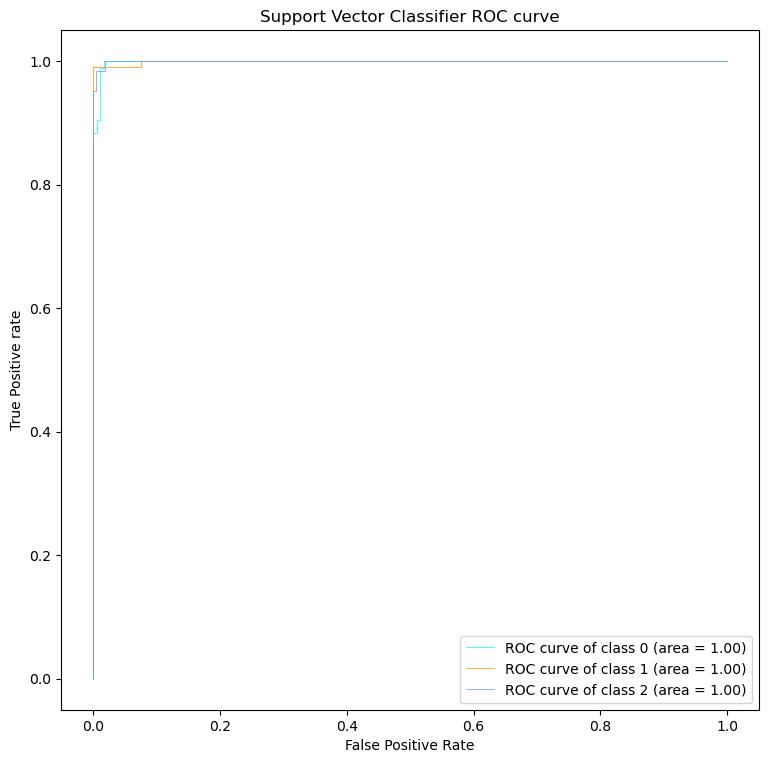

In [97]:
get_model_metrics(ysvc_test, xsvc_test, bestsvcModel, "Support Vector Classifier")

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        95
           1       1.00      0.99      1.00       110
           2       0.98      0.98      0.98        63

    accuracy                           0.99       268
   macro avg       0.99      0.99      0.99       268
weighted avg       0.99      0.99      0.99       268



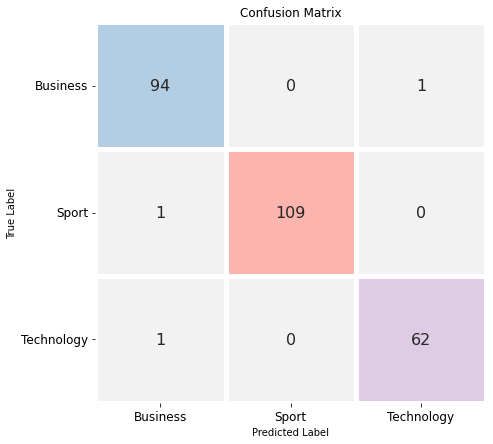

In [91]:
get_reports(ysvc_test, bestsvcModel.predict(xsvc_test))

### **Logistic Regression Classifier**

In [103]:
lr_param = {
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', "sag"],
    'classifier__penalty': ['l2', "elasticnet"],
    'classifier__C': [10000, 1000, 100, 10, 1.0, 0.1, 0.01, 0.001, 0.0001]
}
bestLrScore, bestLrparam, bestLrModel, xlr_test, ylr_test = get_best_model(article, le_trans, LogisticRegression(), lr_param)

Best Cross Validation Score: 0.9803356256979957


In [222]:
bestLrparam

{'tfidf__tokenizer': <function __main__.snowball_stemmer(text)>,
 'tfidf__stop_words': 'english',
 'tfidf__min_df': 11,
 'classifier__solver': 'newton-cg',
 'classifier__penalty': 'l2',
 'classifier__C': 1000}

**Logistic Regression Performance Measurements**

ROC_AUC_Score 0.9991492203952284
Accuracy 0.9925373134328358


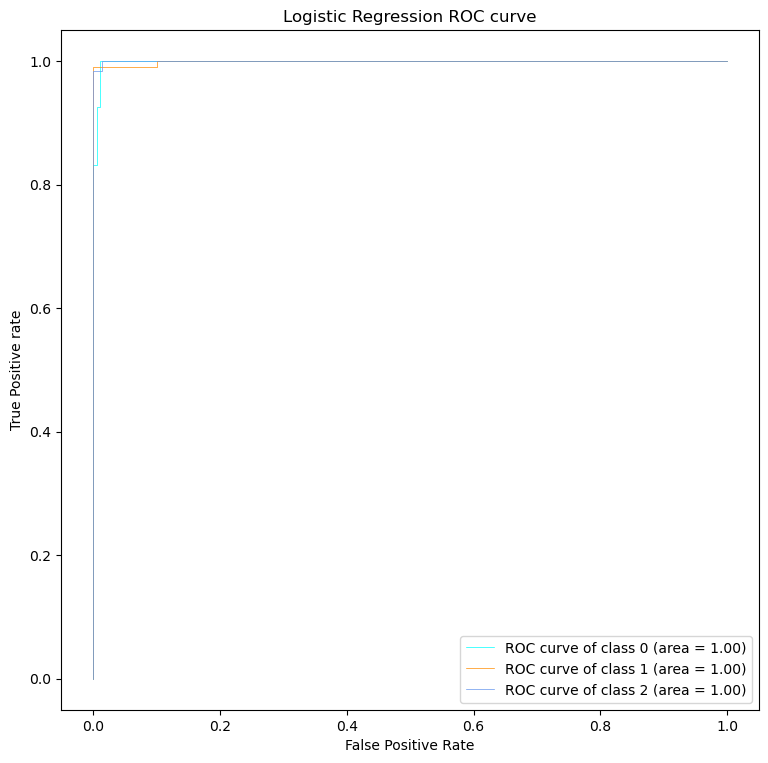

In [104]:
get_model_metrics(ylr_test, xlr_test, bestLrModel, "Logistic Regression")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        95
           1       1.00      0.99      1.00       110
           2       1.00      0.98      0.99        63

    accuracy                           0.99       268
   macro avg       0.99      0.99      0.99       268
weighted avg       0.99      0.99      0.99       268



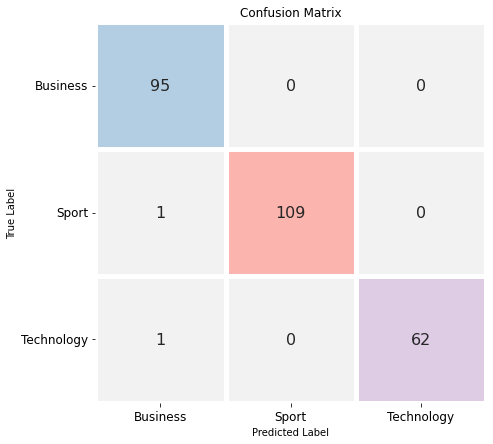

In [105]:
get_reports(ylr_test, bestLrModel.predict(xlr_test))

### **Random Forest Classifier**

In [107]:
rf_param = {'classifier__max_depth': [6,9, None], 
         'classifier__n_estimators':[50, 70, 100, 150], 
          'classifier__max_features': np.arange(1,6),
          'classifier__criterion' : ['gini', 'entropy'],
          'classifier__bootstrap':[True, False],
          'classifier__min_samples_leaf': np.arange(1,4)
        }
bestRfScore, bestRfparam, bestRfModel, xRf_test, yRf_test = get_best_model(article, le_trans, RandomForestClassifier(), rf_param)

Best Cross Validation Score: 0.9619202962440487


In [223]:
bestRfparam

{'tfidf__tokenizer': <function __main__.porter_stemmer(text)>,
 'tfidf__stop_words': 'english',
 'tfidf__min_df': 11,
 'classifier__n_estimators': 150,
 'classifier__min_samples_leaf': 2,
 'classifier__max_features': 5,
 'classifier__max_depth': None,
 'classifier__criterion': 'gini',
 'classifier__bootstrap': True}

**Random Forest Performance Measurements**

ROC_AUC_Score 0.9982804987053294
Accuracy 0.9664179104477612


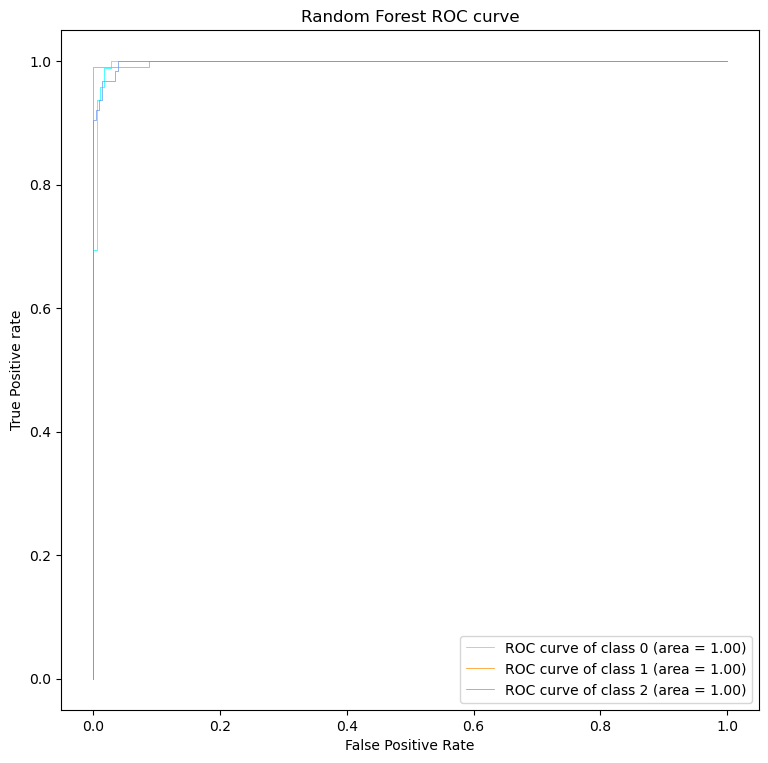

In [109]:
get_model_metrics(yRf_test, xRf_test, bestRfModel, "Random Forest")

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        95
           1       0.97      0.99      0.98       110
           2       1.00      0.87      0.93        63

    accuracy                           0.97       268
   macro avg       0.97      0.95      0.96       268
weighted avg       0.97      0.97      0.97       268



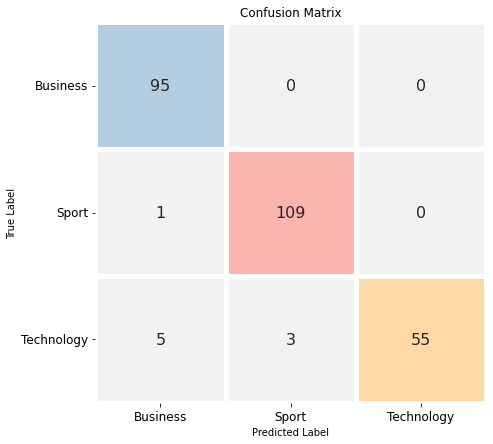

In [110]:
get_reports(yRf_test, bestRfModel.predict(xRf_test))

### **Gradient Boosting Classifier**

In [112]:
gbd_param = {
    "classifier__loss" : ["deviance", "exponential"],
    "classifier__learning_rate": [1, 0.1, 0.01, 0.001],
    "classifier__n_estimators": [10, 100, 1000],
    "classifier__max_depth": np.arange(3,10),
    "classifier__max_leaf_nodes": np.arange(3,10)
}

bestgbScore, bestgbparam, bestgbModel, xgb_test, ygb_test = get_best_model(article, le_trans, GradientBoostingClassifier(), gbd_param)

Best Cross Validation Score: 0.9712719684946808


In [224]:
bestgbparam

{'tfidf__tokenizer': <function __main__.lancaster_stemmer(text)>,
 'tfidf__stop_words': 'english',
 'tfidf__min_df': 4,
 'classifier__n_estimators': 1000,
 'classifier__max_leaf_nodes': 4,
 'classifier__max_depth': 4,
 'classifier__loss': 'deviance',
 'classifier__learning_rate': 0.1}

**Gradient Boosting Classifier Performance Measurements**

ROC_AUC_Score 0.9979023907107051
Accuracy 0.9738805970149254


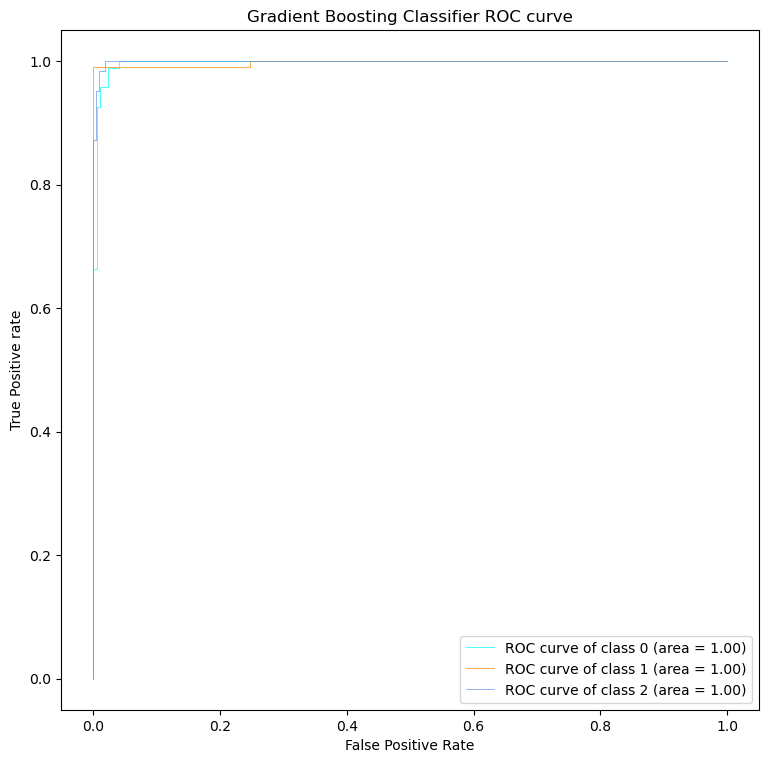

In [113]:
get_model_metrics(ygb_test, xgb_test, bestgbModel, "Gradient Boosting Classifier")

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        95
           1       0.99      0.99      0.99       110
           2       0.97      0.95      0.96        63

    accuracy                           0.97       268
   macro avg       0.97      0.97      0.97       268
weighted avg       0.97      0.97      0.97       268



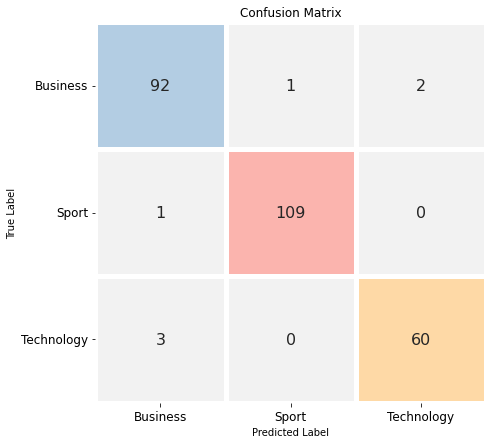

In [114]:
get_reports(ygb_test, bestgbModel.predict(xgb_test))

### **Multi-layer Perceptron Classifier**

In [68]:
from sklearn.neural_network import MLPClassifier

In [70]:
mlp = MLPClassifier(max_iter=150)
mlp_param = {
    'classifier__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (100, 100)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.0001, 0.05],
    'classifier__learning_rate': ['constant','adaptive'],
}
bestmlpScore, bestmlpparam, bestmlpModel, xmlp_test, ymlp_test = get_best_model(article, le_trans, mlp, mlp_param)

Best Cross Validation Score: 0.9822077235055547


In [71]:
bestmlpparam

{'tfidf__tokenizer': <function __main__.snowball_stemmer(text)>,
 'tfidf__stop_words': 'english',
 'tfidf__min_df': 9,
 'classifier__solver': 'adam',
 'classifier__learning_rate': 'constant',
 'classifier__hidden_layer_sizes': (100,),
 'classifier__alpha': 0.05,
 'classifier__activation': 'relu'}

**Multi-layer Perceptron Classifier Performance Measurements**

ROC_AUC_Score 0.9993675203860706
Accuracy 0.9925373134328358


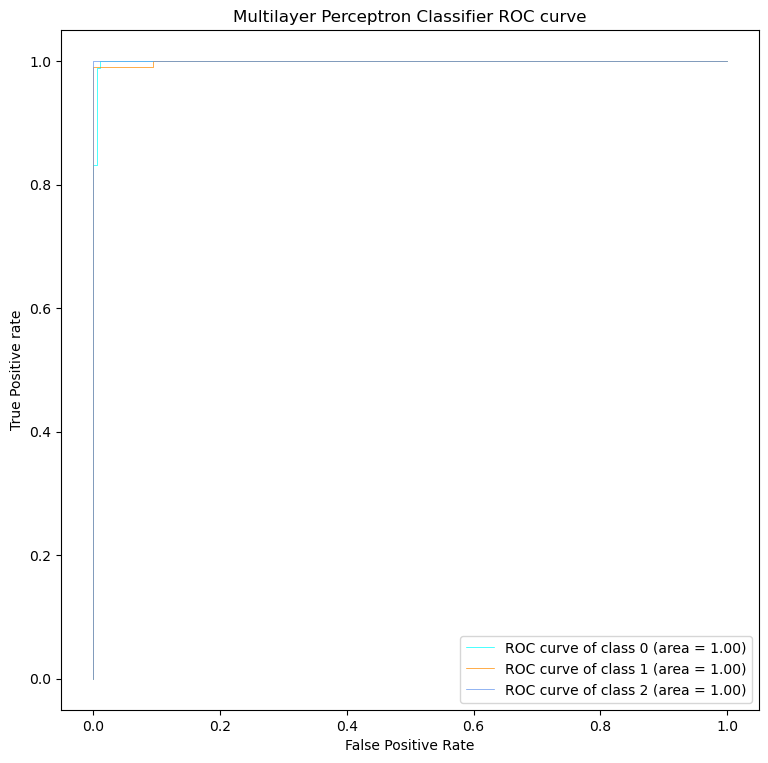

In [115]:
get_model_metrics(ymlp_test, xmlp_test, bestmlpModel, "Multilayer Perceptron Classifier")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        95
           1       1.00      0.99      1.00       110
           2       1.00      0.98      0.99        63

    accuracy                           0.99       268
   macro avg       0.99      0.99      0.99       268
weighted avg       0.99      0.99      0.99       268



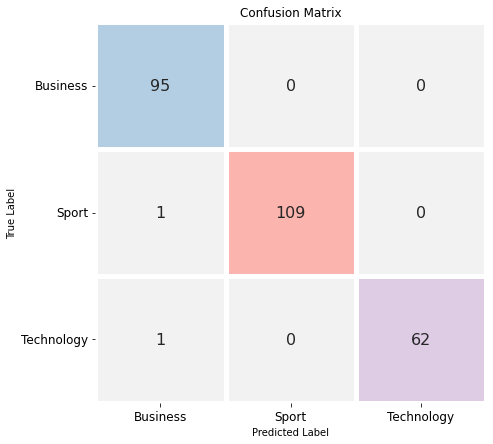

In [116]:
get_reports(ymlp_test, bestmlpModel.predict(xmlp_test))

### **Stochastic Gradient Descent Classifier**

In [119]:
sgd_params = {
    "classifier__loss": ['log', 'modified_huber'],
    "classifier__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "classifier__learning_rate": ['constant', 'optimal', 'invscaling', 'adaptive'],
    "classifier__class_weight": [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
    "classifier__eta0": [1, 10, 100] 
}

sgd = SGDClassifier(max_iter=20) 
bestsgdScore, bestsgdparam, bestsgdModel, xsgd_test, ysgd_test = get_best_model(article, le_trans, sgd, sgd_params)

Best Cross Validation Score: 0.9803356256979957


In [225]:
bestsgdparam

{'tfidf__tokenizer': <function __main__.porter_stemmer(text)>,
 'tfidf__stop_words': 'english',
 'tfidf__min_df': 10,
 'classifier__loss': 'modified_huber',
 'classifier__learning_rate': 'adaptive',
 'classifier__eta0': 1,
 'classifier__class_weight': {1: 0.4, 0: 0.6},
 'classifier__alpha': 0.0001}

**Stochastic Gradient Descent Classifier Performance Measurements**

ROC_AUC_Score 0.9988542178073797
Accuracy 0.9925373134328358


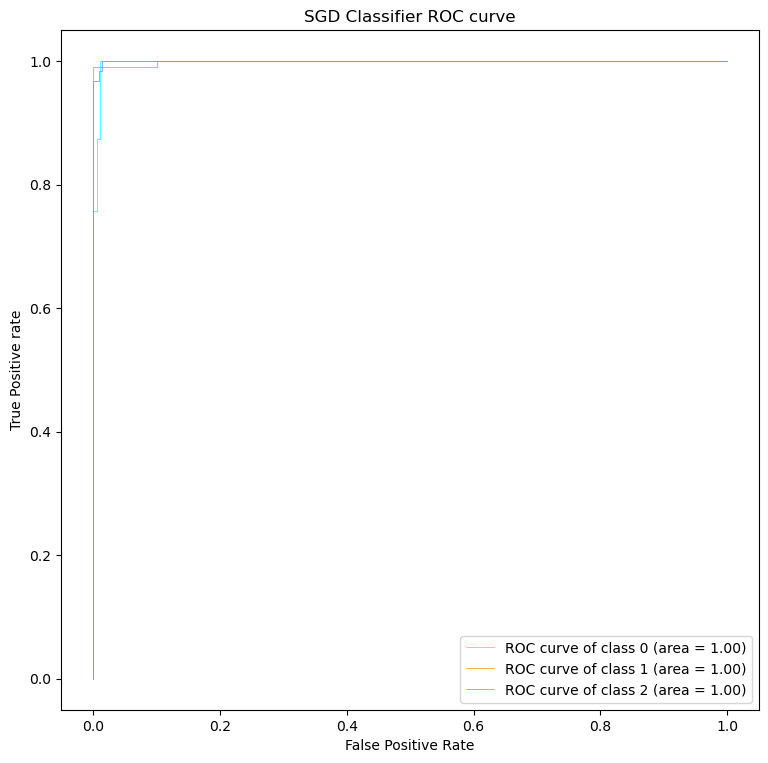

In [120]:
get_model_metrics(ysgd_test, xsgd_test, bestsgdModel, "SGD Classifier")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        95
           1       1.00      0.99      1.00       110
           2       1.00      0.98      0.99        63

    accuracy                           0.99       268
   macro avg       0.99      0.99      0.99       268
weighted avg       0.99      0.99      0.99       268



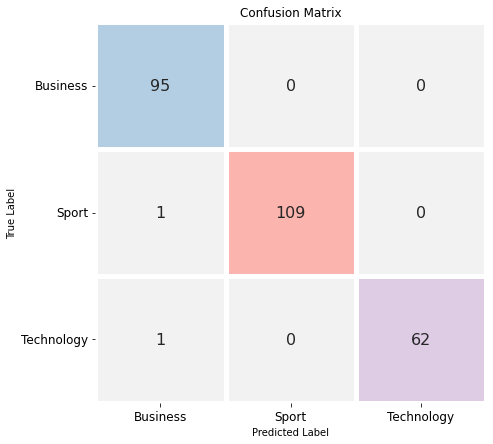

In [121]:
get_reports(ysgd_test, bestsgdModel.predict(xsgd_test))

## **Evaluation Function**

In [85]:
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, classification_report, confusion_matrix, log_loss

<font color = "grey">Assign all of the accuracy and ROC AUC score of each model to the variables</font>

In [95]:
all_accuracy = {}
all_rocauc_score = {}

**"get_model_metrics" function for plot the ROC Curve of the model passed in as well as store the important metrics for further comparison**

In [191]:
def get_model_metrics(yfortest, xtest, model, model_name):
    # define the variable for storing "false positive rate", "true positive rate", and "roc auc score"
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # define number of class and loop through for calculating the rate of each class
    n_class = 3
    for class_num in range(n_class):    
        fpr[class_num], tpr[class_num], _ = roc_curve(yfortest, model.predict_proba(xtest)[:,class_num], pos_label=class_num)
        roc_auc[class_num] = auc(fpr[class_num], tpr[class_num])
        
        
    # plot the roc curve of each class
    plt.figure(figsize=(9, 9), dpi=100)
    colors = ["aqua", "darkorange", "cornflowerblue"]
    for j, color in zip(range(n_class), colors):
        plt.plot(
            fpr[j],
            tpr[j],
            color=color,
            label="ROC curve of class {0} (area = {1:0.2f})".format(j, roc_auc[j]),
            linewidth=0.5,
        )
    
    # append the accuracy and the roc auc score to the assigned dictionary 
    all_accuracy[model_name] = [accuracy_score(yfortest, model.predict(xtest))]
    all_rocauc_score[model_name] = [roc_auc_score(yfortest, model.predict_proba(xtest), multi_class ="ovr")]
    
    #print the ROC AUC score and the accuracy, also specify other attribute for the plot
    print("ROC_AUC_Score " + str(roc_auc_score(yfortest, model.predict_proba(xtest), multi_class ="ovr")))
    print("Accuracy " + str(accuracy_score(yfortest, model.predict(xtest))))
    plt.title(model_name + ' ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc="lower right")
    plt.show()

**"get_reports" function for report the classification reports and plot the confusion metrix**

In [192]:
def get_reports(y_true, y_predict):
    # perform print the classification report using the true target and the prediction
    print(classification_report(y_true, y_predict))
    
    # get the confusion matrix and assign to the cm also transform to the dataframe
    cm = confusion_matrix(y_true, y_predict)
    ranges = ["Business", "Sport", "Technology"]
    df = pd.DataFrame(columns=ranges, index= ranges, data= cm)
    
    # plot the confusion matrix and specify the attributes
    f,ax = plt.subplots(figsize=(7,7))
    sns.heatmap(df, annot=True,cmap="Pastel1_r", fmt= '.0f',
                ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
    plt.xlabel("Predicted Label")
    plt.xticks(size = 12)
    plt.yticks(size = 12, rotation = 0)
    plt.ylabel("True Label")
    plt.title("Confusion Matrix", size = 12)
    plt.show()

## **Model Comparison**

Accumulate all of the metrics used to measure to the into the dataframe

In [189]:
# Assign variable for dataframe storage
accuracy_df = pd.DataFrame(all_accuracy)
rocauc_df = pd.DataFrame(all_rocauc_score)
bestCVscore = pd.DataFrame({
    "Support Vector Classifier": [bestsvcScore],
    "Logistic Regression" : [bestLrScore],
    "Random Forest" : [bestRfScore],
    "Gradient Boosting Classifier": [bestgbScore],
    "Multi-layer Perceptron": [bestmlpScore],
    "SGD Classifier": [bestsgdScore]
})

assign new index to each metrics dataframe and combine together

In [210]:
accuracy_df["metrics"] = "Accuracy"
rocauc_df["metrics"] = "ROC AUC Score"
bestCVscore["metrics"] = "Best CV Score"
accuracy_df.set_index(["metrics"], inplace=True)
rocauc_df.set_index(["metrics"], inplace=True)
bestCVscore.set_index(["metrics"], inplace=True)
combined_metrics = accuracy_df.append(rocauc_df).append(bestCVscore)

In [219]:
combined_metrics

,Support Vector Classifier,Logistic Regression,Random Forest,Gradient Boosting Classifier,Multilayer Perceptron Classifier,SGD Classifier
metrics,,,,,,
Accuracy,0.988806,0.992537,0.966418,0.973881,0.992537,0.992537
ROC AUC Score,0.999189,0.999149,0.998280,0.997902,0.999368,0.998854
Best CV Score,0.980339,0.980336,0.961920,0.971272,0.982208,0.980336


### **Accuracy Comparison Plot**

- Logistic Regression
- Multi-layer Perceptron
- Stochastic Gradient Descent
**Three of this have same accuracy on the test dataset which is: 0.9925**

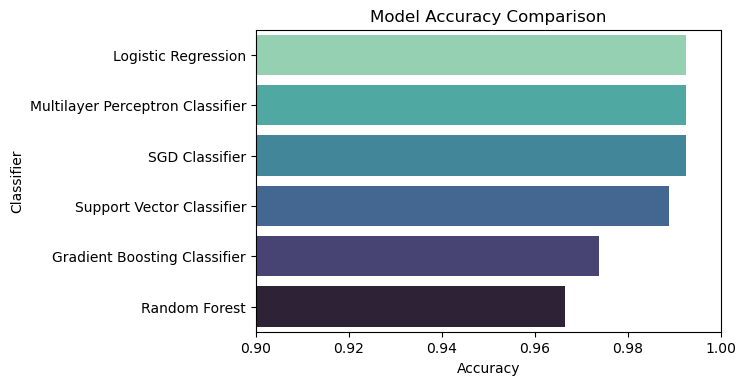

In [186]:
plt.figure(figsize=(6,4), dpi=100)
order_acc = accuracy_df.iloc[0, :].sort_values(ascending=False).index
sns.barplot(y = accuracy_df.columns, x = accuracy_df.iloc[0, :].values, orient="h", palette="mako_r", order = order_acc)
plt.xlim([0.9, 1])
plt.ylabel("Classifier")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

### **ROC AUC Score Comparison Plot**

**The Multi-layer Perceptron is the only one which has the max ROC AUC Score on the test dataset: 0.99936**

The ROC AUC Score is also indicate how well the model can differentiate each class

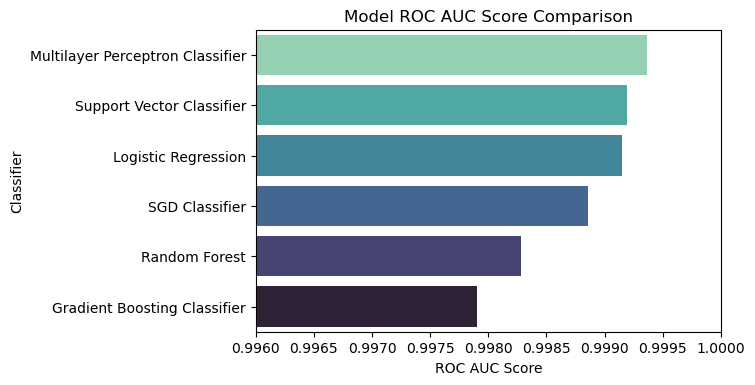

In [187]:
plt.figure(figsize=(6,4), dpi=100)
order_rocauc = rocauc_df.iloc[0, :].sort_values(ascending=False).index
sns.barplot(y = rocauc_df.columns, x = rocauc_df.iloc[0, :].values, orient="h", palette="mako_r", order = order_rocauc)
plt.xlim([0.996, 1])
plt.ylabel("Classifier")
plt.xlabel("ROC AUC Score")
plt.title("Model ROC AUC Score Comparison")
plt.show()

### **Best Cross-Validation Score Comparison Plot**

**The Multi-layer Perceptron is the only one which has the max CV Score on the test dataset: 0.99936**

which also means that the Multi-layer Perceptron is ths most "generalized" model for this text classification context

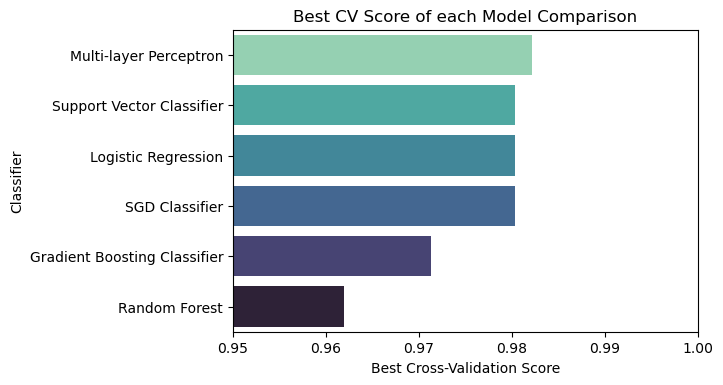

In [188]:
plt.figure(figsize=(6,4), dpi=100)
order_bestCV = bestCVscore.iloc[0, :].sort_values(ascending=False).index
sns.barplot(y = bestCVscore.columns, x = bestCVscore.iloc[0, :].values, orient="h", palette="mako_r", order = order_bestCV)
plt.xlim([0.95, 1])
plt.ylabel("Classifier")
plt.xlabel("Best Cross-Validation Score")
plt.title("Best CV Score of each Model Comparison")
plt.show()

## **Conclusion**

In [220]:
combined_metrics

,Support Vector Classifier,Logistic Regression,Random Forest,Gradient Boosting Classifier,Multilayer Perceptron Classifier,SGD Classifier
metrics,,,,,,
Accuracy,0.988806,0.992537,0.966418,0.973881,0.992537,0.992537
ROC AUC Score,0.999189,0.999149,0.998280,0.997902,0.999368,0.998854
Best CV Score,0.980339,0.980336,0.961920,0.971272,0.982208,0.980336


- Four of the most popular stemming method in the nltk is chosen for tuning in the training pipeline, so the most appropriate stemmer will be selected for each parameter tuning process
- Several important parameters of tokenizer is also specify for finding the best parameters
- RandomizedSearchCV is selected instead of Gridsearch for the reason that RandomSearch take less time and more efficient when we have bunch of parameters
- Each type of model is selected for a reason:
    - Ensemble type of model include Gradient Boosting, Random Forest. These model is popular for solving multi-class problem because they're the combination of multiple model for significantly improve the performance and reduce overfitting problem.
    - Linear Model include Logistic Regression, Stochastic Gradient Descent. These model is selected for classify each class using the linear loss function.
    - Support Vector Classifier is popular model for finding the best hyperplane for classify each class in the problem.
    - Nueral Network including Multi-layer Perceptron. one of the popular model that leverage nueral-network for solving classification
- Each of model is tuned using the RandomSearchCV method as mentioned above and the particular ranges of parameter specificly defined for each model to get both best parameter and estimator
- Evaluation methods that are selected:
    - ROC Curve and ROC AUC Score for explain how well the model differentiate each class of the articles.
    - Confusion Matrix with other metrics from classification_reports is use for visualize and explain how well the model predict each class
    - Best Cross-Validation Score is used to explain how well the each model is generalized to the text classification problem with the best tuned parameters.
- <font color = "indigo">The Best Perform Model is "Multi-layer Perceptron Classifier"</font> with the metrics:
    - Best CV Score: 0.982 (indicate that this model is the most generalized to this text classification problem)
    - ROC AUC Score: 0.9993
    - Accuracy: 0.9925
    
    with these parameters which is tuned by RandomizedSearchCV:
    - tokenizer: snowball_stemmer
    - stop_words: english
    - min_df: 9
    - solver: adam
    - learning_rate: constant
    - hidden_layer_sizes: (100,)
    - alpha: 0.05
    - activation: relu